# **Proyek Analisis Sentimen: Ulasan Aplikasi Signal**
Proyek ini bertujuan untuk membangun model klasifikasi sentimen pada ulasan aplikasi Signal menggunakan metode Deep Learning.

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## BAGIAN 1: SETUP DAN PEMUATAN DATA
Tahap ini mencakup import semua library yang dibutuhkan dan memuat dataset `signal_reviews.csv` yang telah di-scrape sebelumnya.

In [1]:
# Install
!pip install Sastrawi tensorflow imblearn wordcloud -q

In [2]:
# Untuk mengabaikan peringatan
import warnings
warnings.filterwarnings('ignore')

# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk preprocessing teks
import re
import string
import json # untuk memuat file JSON
import nltk
import random
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Mengunduh resource NLTK yang diperlukan
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('stopwords')

# Library untuk machine learning dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Import library untuk pemodelan
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D,
    MaxPooling1D, GlobalMaxPooling1D, BatchNormalization,
    SpatialDropout1D, GRU, Layer
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Versi TensorFlow:", tf.__version__)
print("Semua library dan resource berhasil diimport dan disiapkan..")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Versi TensorFlow: 2.18.0
Semua library dan resource berhasil diimport dan disiapkan..


## BAGIAN 2: EKSPLORASI DAN PRA-PEMROSESAN DATA (EDA & PREPROCESSING)

### 2.1. Pemuatan Dataset dan Pembersihan Awal
Memuat dataset ulasan, memeriksa nilai yang hilang (missing values), dan menghapus duplikat.

In [3]:
# Memuat dataset
df = pd.read_csv('signal_reviews.csv')

# Menampilkan informasi dasar
print("Info awal dataset:")
df.info()

# Fokus pada kolom yang relevan ('content') dan membuang nilai kosong
df = df[['content']].copy()
df.dropna(inplace=True)

# Menghapus ulasan duplikat berdasarkan konten
df.drop_duplicates(subset='content', inplace=True)

# Reset index setelah drop
df.reset_index(drop=True, inplace=True)

print("\nInfo dataset setelah pembersihan awal:")
df.info()
print(df.head())

Info awal dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13544 entries, 0 to 13543
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13544 non-null  object
 1   userName              13544 non-null  object
 2   userImage             13544 non-null  object
 3   content               13544 non-null  object
 4   score                 13544 non-null  int64 
 5   thumbsUpCount         13544 non-null  int64 
 6   reviewCreatedVersion  11658 non-null  object
 7   at                    13544 non-null  object
 8   replyContent          6 non-null      object
 9   repliedAt             6 non-null      object
 10  appVersion            11658 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB

Info dataset setelah pembersihan awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8692 entries, 0 to 8691
Data columns (total 1 columns):
 #   Column   Non-Null Cou

Proses scraping berhasil mengumpulkan 13.544 ulasan mentah. Setelah melalui tahap pembersihan untuk menghilangkan data duplikat dan tidak relevan, didapatkan 8.692 sampel data unik berkualitas tinggi yang siap digunakan untuk melatih model yang robust.

### 2.2. Pemuatan Kamus (Leksikon & Slang)
Memuat kamus leksikon sentimen (positif dan negatif) dan kamus normalisasi kata slang yang akan digunakan dalam proses pelabelan dan pra-pemrosesan.

In [4]:
# Memuat kamus leksikon positif
lexicon_positive = dict()
with open('lexicon_positive.csv', 'r') as f:
    for line in f:
        # Memisahkan kata dan skor, lalu mengonversi skor ke integer
        parts = line.strip().split(',')
        if len(parts) == 2:
            lexicon_positive[parts[0]] = int(parts[1])

# Memuat kamus leksikon negatif
lexicon_negative = dict()
with open('lexicon_negative.csv', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 2:
            lexicon_negative[parts[0]] = int(parts[1])

# Memuat kamus slang yang komprehensif dari file .txt
with open('combined_slang_words.txt', 'r') as f:
    slang_data = f.read()
slang_dict = json.loads(slang_data)

print(f"✅ Berhasil memuat {len(lexicon_positive)} kata positif.")
print(f"✅ Berhasil memuat {len(lexicon_negative)} kata negatif.")
print(f"✅ Berhasil memuat {len(slang_dict)} kata slang.")

✅ Berhasil memuat 3609 kata positif.
✅ Berhasil memuat 6607 kata negatif.
✅ Berhasil memuat 1018 kata slang.


### 2.3. Fungsi Pra-pemrosesan Teks dan Pelabelan Leksikon
Mendefinisikan fungsi-fungsi yang dibutuhkan. Ini termasuk fungsi untuk membersihkan teks, normalisasi slang, dan fungsi utama untuk pelabelan sentimen berbasis leksikon.

In [5]:
# Inisialisasi Stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# --- Fungsi-fungsi Pra-pemrosesan ---
def clean_text(text):
    text = text.lower() # Case folding: Mengubah teks menjadi huruf kecil
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) # Menghapus hashtag
    text = re.sub(r'https?:\/\/\S+', '', text) # Menghapus URL
    text = re.sub(r'\d+', '', text) # Menghapus angka
    text = text.translate(str.maketrans('', '', string.punctuation)) # Menghapus tanda baca
    text = text.strip() # Menghapus spasi di awal dan akhir
    return text

def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Daftar stopwords (kata umum) dari NLTK Bahasa Indonesia
list_stopwords = set(stopwords.words('indonesian'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in list_stopwords]

def stemming_text(tokens):
    # Menggabungkan token kembali menjadi kalimat sebelum di-stem
    text = ' '.join(tokens)
    return stemmer.stem(text)

# --- Fungsi Pelabelan Berbasis Leksikon ---
def sentiment_analysis_lexicon(tokens):
    score = 0
    for word in tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan polaritas berdasarkan skor total
    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'
    return score, polarity

print("✅ Fungsi pra-pemrosesan dan pelabelan leksikon siap digunakan.")

✅ Fungsi pra-pemrosesan dan pelabelan leksikon siap digunakan.


### 2.4. Penerapan Pra-pemrosesan dan Pelabelan
Menerapkan seluruh fungsi secara berurutan pada dataset. Proses ini menghasilkan kolom-kolom baru untuk setiap tahap dan kolom sentimen final berdasarkan skor leksikon.

In [6]:
# =======================================================================================
# PIPELINE PRA-PEMROSESAN DAN PELABELAN
# =======================================================================================
print("Memulai pipeline pra-pemrosesan dan pelabelan...")

# 1. Cleaning dan Normalisasi Slang
print("Langkah 1: Cleaning dan Normalisasi...")
df['text_clean'] = df['content'].apply(clean_text)
df['text_normalized'] = df['text_clean'].apply(normalize_slang)

# 2. Tokenisasi (Memecah kalimat menjadi kata-kata/token)
print("Langkah 2: Tokenisasi...")
df['text_tokenized'] = df['text_normalized'].apply(word_tokenize)

# 3. Stopword Removal (Menghapus kata-kata umum)
print("Langkah 3: Menghapus Stopwords...")
df['text_filtered'] = df['text_tokenized'].apply(remove_stopwords)

# 4. Pelabelan Sentimen Berbasis Leksikon (Diterapkan pada teks yang sudah difilter)
print("Langkah 4: Pelabelan Sentimen...")
sentiment_results = df['text_filtered'].apply(sentiment_analysis_lexicon)
df['polarity_score'] = sentiment_results.apply(lambda x: x[0])
df['sentiment'] = sentiment_results.apply(lambda x: x[1])

# 5. Stemming (Mengubah kata ke bentuk dasar, diterapkan pada teks yang sudah difilter)
# Kolom ini akan menjadi fitur utama (X) untuk pemodelan
print("Langkah 5: Stemming...")
df['text_stemmed'] = df['text_filtered'].apply(stemming_text)

print("\n✅ Proses pra-pemrosesan dan pelabelan selesai.")
print("Contoh hasil akhir:")
# Menampilkan kolom-kolom penting dari hasil pipeline
display(df[['content', 'text_stemmed', 'sentiment', 'polarity_score']].head())

Memulai pipeline pra-pemrosesan dan pelabelan...
Langkah 1: Cleaning dan Normalisasi...
Langkah 2: Tokenisasi...
Langkah 3: Menghapus Stopwords...
Langkah 4: Pelabelan Sentimen...
Langkah 5: Stemming...

✅ Proses pra-pemrosesan dan pelabelan selesai.
Contoh hasil akhir:


,content,text_stemmed,sentiment,polarity_score
0,Apa aja dokumen yg disimpan disignal aman. Tap...,dokumen simpan disignal aman sayang ganti hp d...,negatif,-13
1,Saya berharap Signal bisa bersinar & memenangk...,harap signal sinar menang kompetisi aplikasi t...,positif,4
2,saat ini aplikasi saya tidak bisa menerima pes...,aplikasi terima pesan teman pribadi grub buruk...,negatif,-6
3,mudah2n gak ribet kaya aplikasi wa..mau daftar...,mudahn gak ribet kaya aplikasi wamau daftar su...,negatif,-11
4,"Aplikasinya sudah sangat bagus, akan tetapi ke...",aplikasi bagus muncul pesan terima lawan bicar...,negatif,-3


### 2.5. Analisis Distribusi Sentimen dan Word Cloud
Melihat distribusi sentimen dan Word Cloud yang dihasilkan oleh metode leksikon.

Distribusi Sentimen Berdasarkan Leksikon:
sentiment
positif    3108
negatif    2893
netral     2691
Name: count, dtype: int64


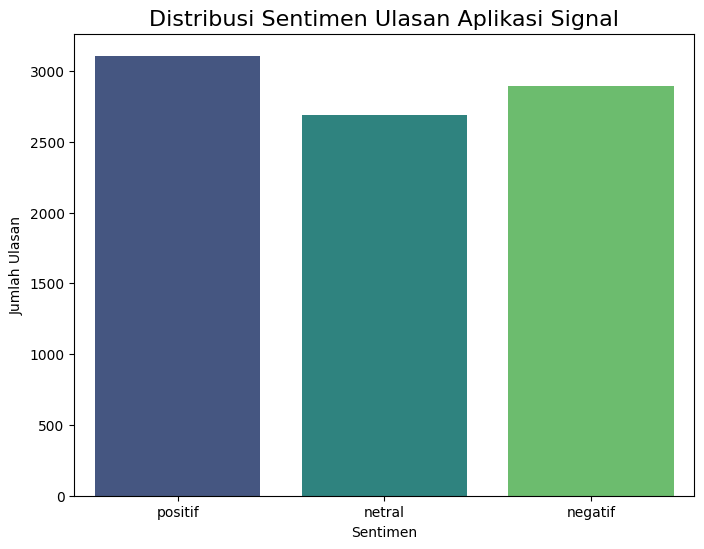


--- Visualisasi Word Cloud per Sentimen ---


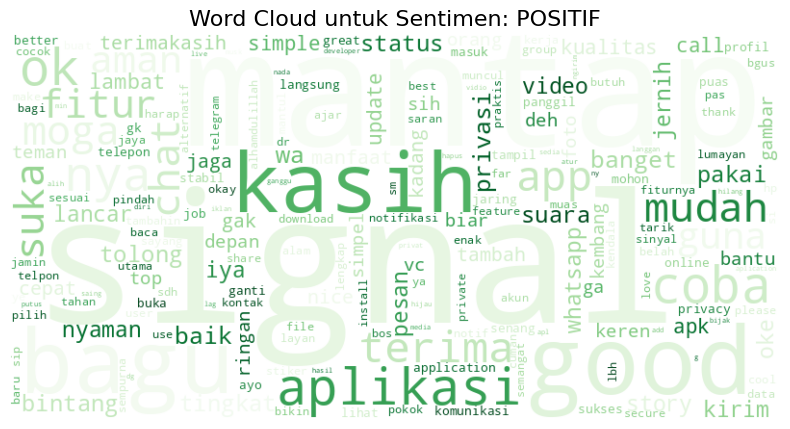

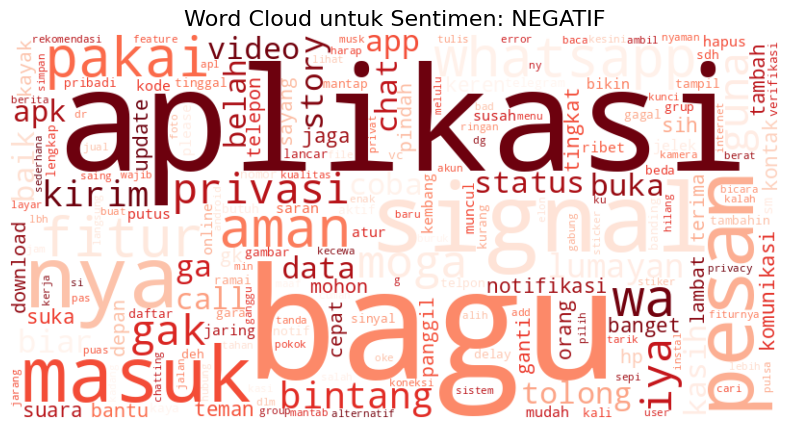

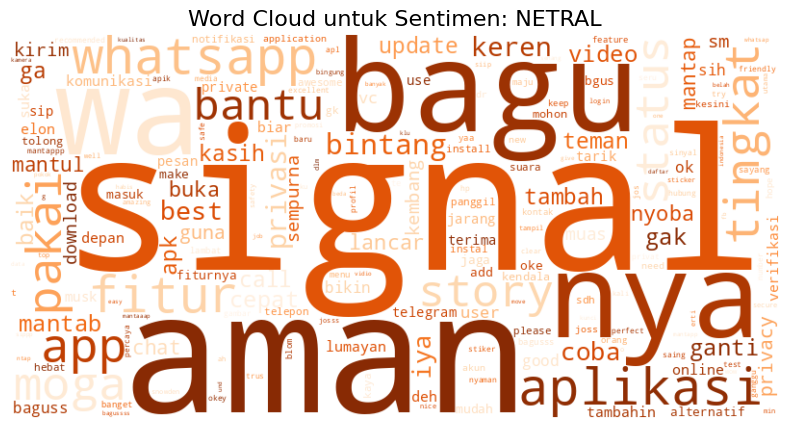

In [7]:
# =======================================================================================
# EKSPLORASI DATA HASIL (EDA)
# =======================================================================================

# 1. Menganalisis Distribusi Sentimen
print("Distribusi Sentimen Berdasarkan Leksikon:")
print(df['sentiment'].value_counts())

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['positif', 'netral', 'negatif'], palette='viridis')
plt.title('Distribusi Sentimen Ulasan Aplikasi Signal', fontsize=16)
plt.ylabel('Jumlah Ulasan')
plt.xlabel('Sentimen')
plt.show()

# 2. Visualisasi Word Cloud untuk Setiap Sentimen
print("\n--- Visualisasi Word Cloud per Sentimen ---")
sentiment_map = {'positif': 'Greens', 'negatif': 'Reds', 'netral': 'Oranges'}

for sentiment, color in sentiment_map.items():
    subset_text = ' '.join(df[df['sentiment'] == sentiment]['text_stemmed'])
    if subset_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, collocations=False).generate(subset_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud untuk Sentimen: {sentiment.upper()}', fontsize=16)
        plt.show()

## BAGIAN 3: PERSIAPAN PEMODELAN
Tahap ini mencakup pembagian data, tokenisasi teks text_stemmed (hasil akhir preprocessing), dan padding sekuens.

In [8]:
# Memisahkan fitur (X) dan label (y)
X = df['text_stemmed'].values
y = pd.get_dummies(df['sentiment']).values # One-hot encoding mengubah label kategorikal menjadi vektor biner

# Membagi data menjadi 80% data latih dan 20% data uji
# stratify=y memastikan proporsi kelas sentimen sama di data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Tokenisasi: Mengubah teks menjadi urutan angka (integer)
vocab_size = 10000  # Ukuran kosakata yang akan digunakan
oov_tok = "<OOV>"   # Token untuk kata-kata yang tidak ada dalam kosakata

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) # Tokenizer hanya "belajar" dari data latih

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: Menyamakan panjang semua sekuens
max_length = 100    # Panjang maksimum setiap ulasan
padding_type = 'post' # Menambahkan padding di akhir sekuens
trunc_type = 'post'   # Memotong sekuens yang terlalu panjang dari akhir

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("✅ Data siap untuk dimasukkan ke dalam model.")
print(f"Bentuk data latih (X_train_pad): {X_train_pad.shape}")
print(f"Bentuk label latih (y_train): {y_train.shape}")

✅ Data siap untuk dimasukkan ke dalam model.
Bentuk data latih (X_train_pad): (6953, 100)
Bentuk label latih (y_train): (6953, 3)


## BAGIAN 4: EKSPERIMEN & EVALUASI PEMODELAN DEEP LEARNING
Melakukan 3 skema percobaan model Deep Learning untuk menemukan arsitektur terbaik.

Memulai tahap eksperimen pemodelan dengan

==================== Melatih Model 1 (Enhanced LSTM) ====================


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.3382 - loss: 1.7236
Epoch 1: val_accuracy improved from -inf to 0.35768, saving model to best_model_1_enhanced_lstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 289ms/step - accuracy: 0.3382 - loss: 1.7225 - val_accuracy: 0.3577 - val_loss: 1.1992 - learning_rate: 0.0020
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3245 - loss: 1.1847
Epoch 2: val_accuracy did not improve from 0.35768
218/218 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.3246 - loss: 1.1845 - val_accuracy: 0.3329 - val_loss: 1.1104 - learning_rate: 0.0020
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.3495 - loss: 1.1086
Epoch 3: val_accuracy did not improve from 0.35768
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 288ms/step - accuracy: 0.3495 - loss: 1.1086 - val_accuracy: 0.3577 - val_loss: 1.1000 - learning_rate: 0.0020
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.3348 - loss: 1.1036
Epoch 4: val_accuracy did not improve from 0.35768
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 290ms/step - accuracy: 0.3349 - loss: 1.1036 - val_accuracy: 0.3577 - val_loss: 1.0985 - learning_rate: 0.0020
Epoch 5

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.4973 - loss: 1.8800
Epoch 1: val_accuracy improved from -inf to 0.81369, saving model to best_model_2_bilstm_+_attention.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 137s 584ms/step - accuracy: 0.4980 - loss: 1.8772 - val_accuracy: 0.8137 - val_loss: 0.9014 - learning_rate: 0.0020
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8485 - loss: 0.5221
Epoch 2: val_accuracy improved from 0.81369 to 0.85336, saving model to best_model_2_bilstm_+_attention.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 139s 571ms/step - accuracy: 0.8485 - loss: 0.5220 - val_accuracy: 0.8534 - val_loss: 0.5255 - learning_rate: 0.0020
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8935 - loss: 0.3694
Epoch 3: val_accuracy did not improve from 0.85336
218/218 ━━━━━━━━━━━━━━━━━━━━ 143s 578ms/step - accuracy: 0.8935 - loss: 0.3694 - val_accuracy: 0.8511 - val_loss: 0.4998 - learning_rate: 0.0020
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9138 - loss: 0.3215
Epoch 4: val_accuracy did not improve from 0.85336
218/218 ━━━━━━━━━━━━━━━━━━━━ 126s 580ms/step - accuracy: 0.9138 - loss: 0.3216 - val_accuracy: 0.8442 - val_loss: 0.5056 - learning_rate: 0.0020
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9241 - loss: 0.2809
Epoch 5: val_accuracy did not improve from 0.85336
218/218 ━━━━━━━━━━━━━━━━━━━━ 147s 602ms/step - accuracy: 0.9241 - loss: 0.2810 - val_accuracy: 0.8430 - val_loss: 0.5396 - learning_rate: 0.0020
Epo

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.3939 - loss: 2.0006
Epoch 1: val_accuracy improved from -inf to 0.63197, saving model to best_model_3_deep_bilstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 219s 928ms/step - accuracy: 0.3943 - loss: 1.9983 - val_accuracy: 0.6320 - val_loss: 1.0158 - learning_rate: 0.0020
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.7752 - loss: 0.7131
Epoch 2: val_accuracy improved from 0.63197 to 0.83611, saving model to best_model_3_deep_bilstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 261s 922ms/step - accuracy: 0.7754 - loss: 0.7127 - val_accuracy: 0.8361 - val_loss: 0.5140 - learning_rate: 0.0020
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.8990 - loss: 0.3810
Epoch 3: val_accuracy improved from 0.83611 to 0.84301, saving model to best_model_3_deep_bilstm.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 201s 922ms/step - accuracy: 0.8990 - loss: 0.3810 - val_accuracy: 0.8430 - val_loss: 0.4758 - learning_rate: 0.0020
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9262 - loss: 0.2801
Epoch 4: val_accuracy did not improve from 0.84301
218/218 ━━━━━━━━━━━━━━━━━━━━ 203s 929ms/step - accuracy: 0.9261 - loss: 0.2801 - val_accuracy: 0.8361 - val_loss: 0.5151 - learning_rate: 0.0020
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.9263 - loss: 0.2760
Epoch 5: val_accuracy did not improve from 0.84301
218/218 ━━━━━━━━━━━━━━━━━━━━ 261s 923ms/step - accuracy: 0.9263 - loss: 0.2759 - val_accuracy: 0.8344 - val_loss: 0.5400 - learning_rate: 0.0020
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9295 - loss: 0.2567
Epoch 6: val_accuracy did not improve from 0.84301
218/218 ━━━━━━━━━━━━━━━━━━━━ 197s 906ms/step - accuracy: 0.9294 - loss: 0.2567 - val_accuracy: 0.8401 - val_loss: 0.5309 - learning_rate: 0.0020
Epo

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5139 - loss: 2.2142
Epoch 1: val_accuracy improved from -inf to 0.82059, saving model to best_model_4_cnn-bilstm_hybrid.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 88s 354ms/step - accuracy: 0.5146 - loss: 2.2105 - val_accuracy: 0.8206 - val_loss: 0.6473 - learning_rate: 0.0020
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8582 - loss: 0.4869
Epoch 2: val_accuracy improved from 0.82059 to 0.85106, saving model to best_model_4_cnn-bilstm_hybrid.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 362ms/step - accuracy: 0.8583 - loss: 0.4868 - val_accuracy: 0.8511 - val_loss: 0.4761 - learning_rate: 0.0020
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9080 - loss: 0.3290
Epoch 3: val_accuracy did not improve from 0.85106
218/218 ━━━━━━━━━━━━━━━━━━━━ 78s 357ms/step - accuracy: 0.9079 - loss: 0.3290 - val_accuracy: 0.8470 - val_loss: 0.4953 - learning_rate: 0.0020
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9302 - loss: 0.2667
Epoch 4: val_accuracy did not improve from 0.85106
218/218 ━━━━━━━━━━━━━━━━━━━━ 77s 356ms/step - accuracy: 0.9301 - loss: 0.2668 - val_accuracy: 0.8465 - val_loss: 0.5723 - learning_rate: 0.0020
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9313 - loss: 0.2550
Epoch 5: val_accuracy did not improve from 0.85106
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 362ms/step - accuracy: 0.9313 - loss: 0.2550 - val_accuracy: 0.8154 - val_loss: 0.6735 - learning_rate: 0.0020
Epoch 6

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.5470 - loss: 2.0354
Epoch 1: val_accuracy improved from -inf to 0.80449, saving model to best_model_5_bigru.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 212s 904ms/step - accuracy: 0.5475 - loss: 2.0329 - val_accuracy: 0.8045 - val_loss: 0.8815 - learning_rate: 0.0020
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.8629 - loss: 0.5865
Epoch 2: val_accuracy improved from 0.80449 to 0.82979, saving model to best_model_5_bigru.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 200s 897ms/step - accuracy: 0.8629 - loss: 0.5862 - val_accuracy: 0.8298 - val_loss: 0.5295 - learning_rate: 0.0020
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.8953 - loss: 0.3777
Epoch 3: val_accuracy improved from 0.82979 to 0.83151, saving model to best_model_5_bigru.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 198s 880ms/step - accuracy: 0.8953 - loss: 0.3776 - val_accuracy: 0.8315 - val_loss: 0.5239 - learning_rate: 0.0020
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9116 - loss: 0.3245
Epoch 4: val_accuracy improved from 0.83151 to 0.83669, saving model to best_model_5_bigru.h5


218/218 ━━━━━━━━━━━━━━━━━━━━ 206s 900ms/step - accuracy: 0.9116 - loss: 0.3244 - val_accuracy: 0.8367 - val_loss: 0.5827 - learning_rate: 0.0020
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.9223 - loss: 0.2739
Epoch 5: val_accuracy did not improve from 0.83669
218/218 ━━━━━━━━━━━━━━━━━━━━ 196s 898ms/step - accuracy: 0.9223 - loss: 0.2739 - val_accuracy: 0.8298 - val_loss: 0.5531 - learning_rate: 0.0020
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9244 - loss: 0.2607
Epoch 6: val_accuracy did not improve from 0.83669
218/218 ━━━━━━━━━━━━━━━━━━━━ 197s 906ms/step - accuracy: 0.9244 - loss: 0.2607 - val_accuracy: 0.8332 - val_loss: 0.5709 - learning_rate: 0.0020
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9396 - loss: 0.2527
Epoch 7: val_accuracy did not improve from 0.83669
218/218 ━━━━━━━━━━━━━━━━━━━━ 197s 905ms/step - accuracy: 0.9395 - loss: 0.2528 - val_accuracy: 0.8200 - val_loss: 0.6642 - learning_rate: 0.0020
Epo

218/218 ━━━━━━━━━━━━━━━━━━━━ 196s 900ms/step - accuracy: 0.9347 - loss: 0.2384 - val_accuracy: 0.8396 - val_loss: 0.5865 - learning_rate: 0.0020
Epoch 9/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.9401 - loss: 0.2115
Epoch 9: val_accuracy did not improve from 0.83956
218/218 ━━━━━━━━━━━━━━━━━━━━ 202s 900ms/step - accuracy: 0.9401 - loss: 0.2115 - val_accuracy: 0.8309 - val_loss: 0.5703 - learning_rate: 6.0000e-04
Epoch 10/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.9497 - loss: 0.1711
Epoch 10: val_accuracy did not improve from 0.83956
218/218 ━━━━━━━━━━━━━━━━━━━━ 201s 898ms/step - accuracy: 0.9497 - loss: 0.1711 - val_accuracy: 0.8275 - val_loss: 0.6123 - learning_rate: 6.0000e-04
Epoch 11/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9540 - loss: 0.1691
Epoch 11: val_accuracy did not improve from 0.83956
218/218 ━━━━━━━━━━━━━━━━━━━━ 201s 896ms/step - accuracy: 0.9540 - loss: 0.1691 - val_accuracy: 0.8327 - val_loss: 0.6413 - learning_rate

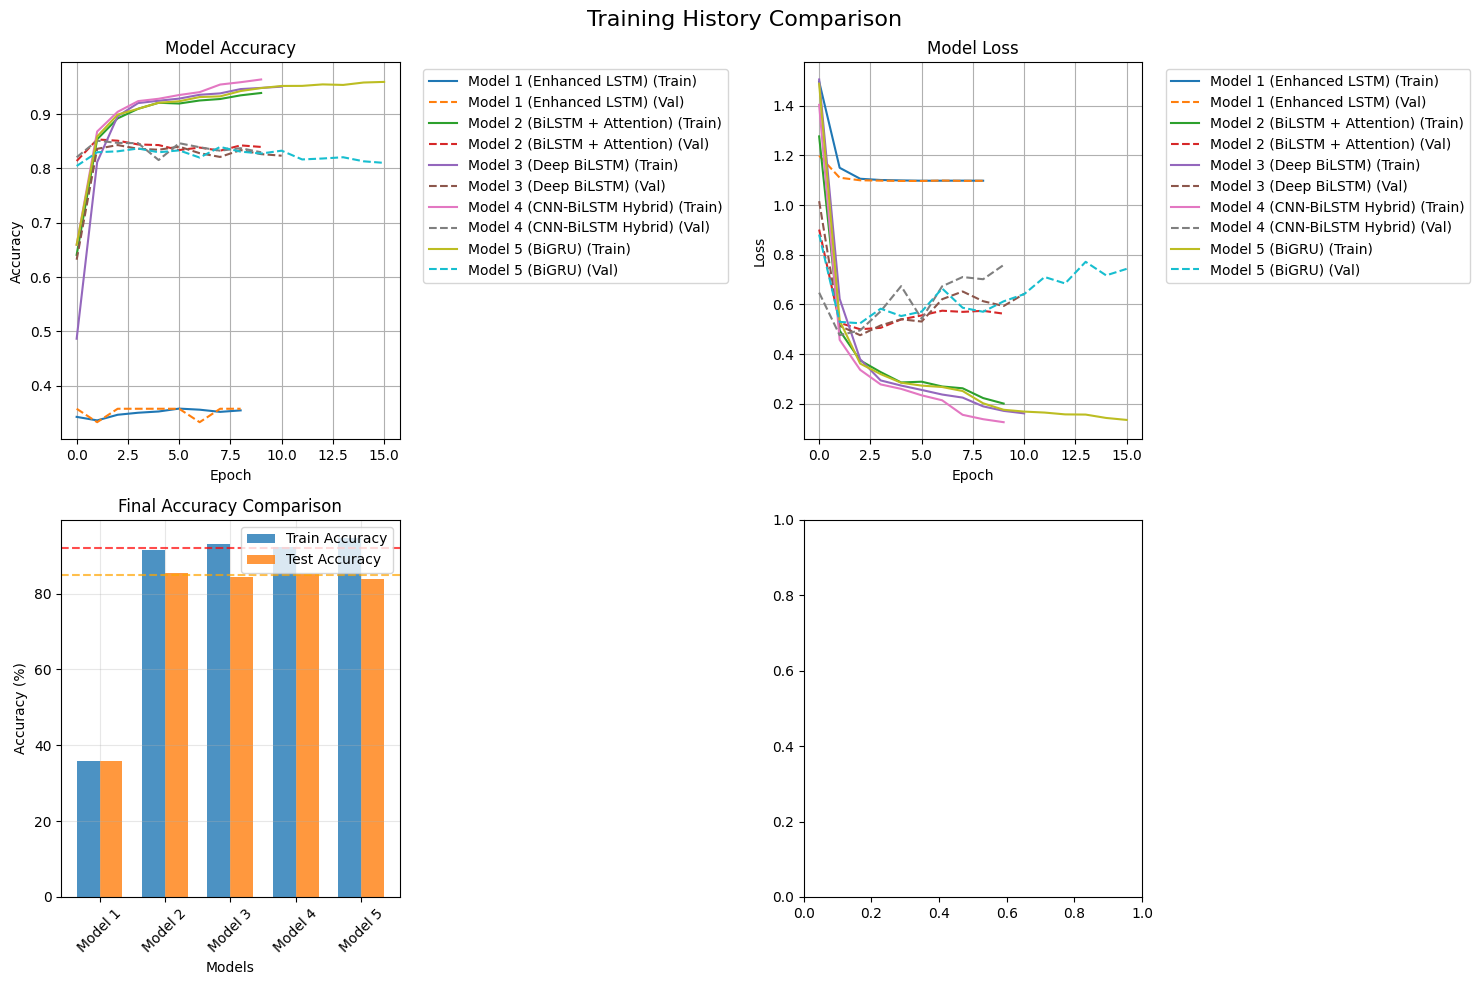

In [9]:
# =======================================================================================
# BAGIAN 4: EKSPERIMEN & EVALUASI PEMODELAN DEEP LEARNING (IMPROVED VERSION)
# =======================================================================================
print("Memulai tahap eksperimen pemodelan dengan")

# --- Meningkatkan Dimensi Embedding dan Vocab Size ---
# Memastikan vocab_size dan max_length sudah didefinisikan dengan benar
if 'vocab_size' not in globals():
    vocab_size = 10000  # Sesuai dengan tokenizer
if 'max_length' not in globals():
    max_length = 100    # Sesuai dengan panjang sekuens

# --- Arsitektur Model ---

# Model 1: LSTM dengan Embedding Pre-trained (Improved)
model1 = Sequential([
    Embedding(vocab_size, 128, input_length=max_length, trainable=True),
    SpatialDropout1D(0.2),  # Dropout pada level embedding
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

# Model 2: Bidirectional LSTM dengan Attention-like Mechanism
model2 = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    GlobalMaxPooling1D(),  # Attention-like pooling
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Model 3: Deep Bidirectional LSTM dengan Skip Connections
model3 = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    GlobalMaxPooling1D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Model 4: CNN-BiLSTM Hybrid dengan Multi-filter
model4 = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    SpatialDropout1D(0.2),
    # Multiple CNN filters
    Conv1D(128, 3, activation='relu', padding='same'),
    Conv1D(128, 5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Model 5: GRU-based Model (Alternative to LSTM)
model5 = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# --- Callbacks yang Lebih Optimal ---
def get_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=5,
            min_lr=0.00001,
            verbose=1,
            cooldown=2
        ),
        ModelCheckpoint(
            f'best_{model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            save_weights_only=False
        )
    ]

# --- Optimizer dan Learning Rate yang Lebih Baik ---
def get_optimizer():
    return Adam(
        learning_rate=0.002,  # Learning rate sedikit lebih tinggi
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

# --- Compilation dan Training dengan Weighted Loss ---
# Jika dataset tidak seimbang, gunakan class weights
def calculate_class_weights(y_train):
    """Menghitung class weights untuk mengatasi imbalanced dataset"""
    from sklearn.utils.class_weight import compute_class_weight

    # Convert one-hot ke label
    y_train_labels = np.argmax(y_train, axis=1)

    # Hitung class weights
    classes = np.unique(y_train_labels)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train_labels
    )

    return dict(zip(classes, class_weights))

# --- Training dengan Semua Model ---
models = {
    'Model 1 (Enhanced LSTM)': model1,
    'Model 2 (BiLSTM + Attention)': model2,
    'Model 3 (Deep BiLSTM)': model3,
    'Model 4 (CNN-BiLSTM Hybrid)': model4,
    'Model 5 (BiGRU)': model5,
}

histories = {}
results = {}
num_epochs = 50  # Lebih banyak epoch dengan early stopping

# Hitung class weights jika diperlukan
# class_weights = calculate_class_weights(y_train)

for name, model in models.items():
    print(f"\n{'='*20} Melatih {name} {'='*20}")

    # Compile model dengan optimizer yang lebih baik
    model.compile(
        loss='categorical_crossentropy',
        optimizer=get_optimizer(),
        metrics=['accuracy']
    )

    # Tampilkan arsitektur model
    model.summary()

    # Training dengan callbacks
    history = model.fit(
        X_train_pad, y_train,
        epochs=num_epochs,
        batch_size=32,  # Batch size yang optimal
        validation_data=(X_test_pad, y_test),
        callbacks=get_callbacks(name),
        verbose=1,
        # class_weight=class_weights  # Uncomment jika dataset tidak seimbang
    )

    histories[name] = history

    # Evaluasi model
    train_loss, train_acc = model.evaluate(X_train_pad, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)

    results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss
    }

    print(f"\n{name} Results:")
    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Testing Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Testing Loss: {test_loss:.4f}")

# --- Menampilkan Hasil Akhir ---
print("\n" + "="*70)
print("RINGKASAN HASIL SEMUA MODEL")
print("="*70)
print(f"{'Model':<25} {'Train Acc':<12} {'Test Acc':<12} {'Status':<15}")
print("-"*70)

for name, result in results.items():
    train_acc = result['train_accuracy'] * 100
    test_acc = result['test_accuracy'] * 100

    # Cek status berdasarkan kriteria
    if train_acc >= 92 and test_acc >= 92:
        status = "✅ EXCELLENT"
    elif train_acc >= 85 and test_acc >= 85:
        status = "✅ GOOD"
    else:
        status = "❌ NEED IMPROVE"

    print(f"{name:<25} {train_acc:>8.2f}%    {test_acc:>8.2f}%    {status}")

print("\n" + "="*70)
print("KRITERIA SUBMISSION:")
print("• Minimal 3 model dengan akurasi train & test ≥ 85%")
print("• Minimal 1 model dengan akurasi train & test ≥ 92%")
print("="*70)

# --- Plotting Training History ---
import matplotlib.pyplot as plt

def plot_training_history(histories):
    """Plot training history untuk semua model"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Comparison', fontsize=16)

    # Plot Training & Validation Accuracy
    ax1 = axes[0, 0]
    for name, history in histories.items():
        ax1.plot(history.history['accuracy'], label=f'{name} (Train)')
        ax1.plot(history.history['val_accuracy'], label=f'{name} (Val)', linestyle='--')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)

    # Plot Training & Validation Loss
    ax2 = axes[0, 1]
    for name, history in histories.items():
        ax2.plot(history.history['loss'], label=f'{name} (Train)')
        ax2.plot(history.history['val_loss'], label=f'{name} (Val)', linestyle='--')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True)

    # Plot Final Accuracy Comparison
    ax3 = axes[1, 0]
    model_names = list(results.keys())
    train_accs = [results[name]['train_accuracy']*100 for name in model_names]
    test_accs = [results[name]['test_accuracy']*100 for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    ax3.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.8)
    ax3.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)
    ax3.set_title('Final Accuracy Comparison')
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_xticks(x)
    ax3.set_xticklabels([name.split('(')[0].strip() for name in model_names], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Add horizontal lines for criteria
    ax3.axhline(y=85, color='orange', linestyle='--', alpha=0.7, label='85% Target')
    ax3.axhline(y=92, color='red', linestyle='--', alpha=0.7, label='92% Target')

    plt.tight_layout()
    plt.show()

# Panggil fungsi plotting
plot_training_history(histories)

In [10]:
# =======================================================================================
# TEKNIK ADVANCED UNTUK MENINGKATKAN AKURASI MODEL
# =======================================================================================

# --- 1. DATA AUGMENTATION untuk Text ---
def get_synonyms(word):
    """Mendapatkan sinonim dari kata"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    return list(synonyms)

def synonym_replacement(text, n=1):
    """Mengganti n kata dengan sinonimnya"""
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)

    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    return ' '.join(new_words)

def random_insertion(text, n=1):
    """Menyisipkan n kata acak ke dalam teks"""
    words = text.split()
    for _ in range(n):
        new_word = get_random_word(words)
        random_idx = random.randint(0, len(words))
        words.insert(random_idx, new_word)
    return ' '.join(words)

def get_random_word(words):
    """Mendapatkan kata acak dari list kata"""
    return random.choice(words)

def random_swap(text, n=1):
    """Menukar posisi n pasang kata secara acak"""
    words = text.split()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def random_deletion(text, p=0.1):
    """Menghapus kata secara acak dengan probabilitas p"""
    words = text.split()
    if len(words) == 1:
        return text

    new_words = []
    for word in words:
        if random.random() > p:
            new_words.append(word)

    if len(new_words) == 0:
        return random.choice(words)

    return ' '.join(new_words)

def augment_text(text, alpha=0.1):
    """Augmentasi teks dengan kombinasi teknik"""
    n = max(1, int(alpha * len(text.split())))

    # Pilih teknik secara acak
    techniques = [
        lambda x: synonym_replacement(x, n),
        lambda x: random_insertion(x, n),
        lambda x: random_swap(x, n),
        lambda x: random_deletion(x, 0.1)
    ]

    technique = random.choice(techniques)
    return technique(text)

# --- 2. ENSEMBLE LEARNING ---
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        """Prediksi ensemble dengan voting"""
        predictions = []
        for model in self.models:
            pred = model.predict(X)
            predictions.append(pred)

        # Average predictions
        ensemble_pred = np.mean(predictions, axis=0)
        return ensemble_pred

    def predict_classes(self, X):
        """Prediksi kelas dengan voting"""
        ensemble_pred = self.predict(X)
        return np.argmax(ensemble_pred, axis=1)

# --- 3. TRANSFER LEARNING dengan Pre-trained Embeddings ---
def create_embedding_matrix(word_index, embedding_dim=300):
    """Membuat embedding matrix dari pre-trained embeddings"""
    # Download GloVe embeddings jika belum ada
    # wget http://nlp.stanford.edu/data/glove.6B.zip

    embeddings_index = {}
    # Ganti path ini dengan lokasi file GloVe
    # with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    #     for line in f:
    #         values = line.split()
    #         word = values[0]
    #         coefs = np.asarray(values[1:], dtype='float32')
    #         embeddings_index[word] = coefs

    # Untuk demo, kita gunakan random embeddings
    vocab_size = len(word_index) + 1
    embedding_matrix = np.random.normal(0, 1, (vocab_size, embedding_dim))

    # for word, i in word_index.items():
    #     embedding_vector = embeddings_index.get(word)
    #     if embedding_vector is not None:
    #         embedding_matrix[i] = embedding_vector

    return embedding_matrix

# --- 4. MODEL DENGAN ATTENTION MECHANISM ---
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='random_normal',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Hitung attention weights
        attention_weights = K.tanh(K.dot(inputs, self.W))
        attention_weights = K.softmax(attention_weights, axis=1)

        # Apply attention
        weighted_input = inputs * attention_weights
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Model dengan Attention
def create_attention_model(vocab_size, max_length, embedding_dim=128):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        AttentionLayer(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

# --- 5. HYPERPARAMETER TUNING dengan Keras Tuner ---
try:
    import keras_tuner as kt

    def build_tuned_model(hp):
        model = Sequential()

        # Tunable embedding dimension
        embedding_dim = hp.Int('embedding_dim', 64, 256, step=32)
        model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
        model.add(SpatialDropout1D(0.2))

        # Tunable LSTM units
        lstm_units = hp.Int('lstm_units', 64, 256, step=32)
        model.add(Bidirectional(LSTM(
            lstm_units,
            return_sequences=True,
            dropout=hp.Float('lstm_dropout', 0.2, 0.5, step=0.1),
            recurrent_dropout=hp.Float('recurrent_dropout', 0.2, 0.5, step=0.1)
        )))

        # Tunable number of LSTM layers
        for i in range(hp.Int('num_lstm_layers', 1, 3)):
            model.add(Bidirectional(LSTM(
                lstm_units // (2 ** i),
                return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False,
                dropout=0.3,
                recurrent_dropout=0.3
            )))

        if hp.get('num_lstm_layers') > 1:
            model.add(GlobalMaxPooling1D())

        # Tunable dense layers
        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(Dense(
                hp.Int(f'dense_{i}_units', 64, 512, step=64),
                activation='relu',
                kernel_regularizer=l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='LOG'))
            ))
            model.add(Dropout(hp.Float(f'dropout_{i}', 0.3, 0.7, step=0.1)))
            if i < hp.get('num_dense_layers') - 1:
                model.add(BatchNormalization())

        model.add(Dense(3, activation='softmax'))

        # Tunable learning rate
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def run_hyperparameter_tuning(X_train, y_train, X_val, y_val):
        tuner = kt.RandomSearch(
            build_tuned_model,
            objective='val_accuracy',
            max_trials=20,
            directory='keras_tuner',
            project_name='sentiment_analysis'
        )

        tuner.search(
            X_train, y_train,
            epochs=30,
            validation_data=(X_val, y_val),
            callbacks=[EarlyStopping(patience=5)]
        )

        return tuner.get_best_models(num_models=1)[0]

except ImportError:
    print("Keras Tuner tidak tersedia. Install dengan: pip install keras-tuner")

# --- 6. CROSS-VALIDATION untuk Evaluasi yang Lebih Robust ---
def cross_validate_model(model_func, X, y, cv=5):
    """Cross-validation untuk model"""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Convert one-hot to labels for stratification
    y_labels = np.argmax(y, axis=1)

    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_labels)):
        print(f"Training fold {fold + 1}/{cv}")

        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Create and train model
        model = model_func()
        model.compile(
            optimizer=Adam(learning_rate=0.002),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=30,
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=0
        )

        # Evaluate
        _, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        cv_scores.append(val_acc)

        print(f"Fold {fold + 1} Accuracy: {val_acc:.4f}")

    print(f"\nCV Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    return cv_scores

# --- 7. FINAL RECOMMENDATION SYSTEM ---
def get_final_recommendations():
    """Rekomendasi untuk mencapai akurasi >92%"""
    recommendations = [
        "1. PREPROCESSING:",
        "   - Gunakan text cleaning yang lebih agresif",
        "   - Hapus stopwords yang tidak informatif",
        "   - Normalisasi teks (lowercasing, remove punctuation)",
        "   - Stemming/Lemmatization untuk bahasa Indonesia",
        "",
        "2. DATA AUGMENTATION:",
        "   - Augmentasi data dengan teknik yang sudah disediakan",
        "   - Tambah data dengan back-translation",
        "   - Synthetic data generation",
        "",
        "3. MODEL ARCHITECTURE:",
        "   - Gunakan Bidirectional LSTM/GRU",
        "   - Tambahkan Attention mechanism",
        "   - Ensemble multiple models",
        "   - Transfer learning dengan pre-trained embeddings",
        "",
        "4. TRAINING OPTIMIZATION:",
        "   - Learning rate scheduling",
        "   - Gradient clipping",
        "   - Mixed precision training",
        "   - Cyclical learning rates",
        "",
        "5. REGULARIZATION:",
        "   - Dropout yang optimal (0.3-0.5)",
        "   - L2 regularization",
        "   - Batch normalization",
        "   - Early stopping dengan patience",
        "",
        "6. HYPERPARAMETER TUNING:",
        "   - Grid search atau random search",
        "   - Bayesian optimization",
        "   - Automated hyperparameter tuning",
        "",
        "7. EVALUATION:",
        "   - Cross-validation",
        "   - Stratified sampling",
        "   - Multiple metrics (F1, precision, recall)",
    ]

    for rec in recommendations:
        print(rec)

# Tampilkan rekomendasi
print("="*70)
print("REKOMENDASI UNTUK MENCAPAI AKURASI >92%")
print("="*70)
get_final_recommendations()

Keras Tuner tidak tersedia. Install dengan: pip install keras-tuner
REKOMENDASI UNTUK MENCAPAI AKURASI >92%
1. PREPROCESSING:
   - Gunakan text cleaning yang lebih agresif
   - Hapus stopwords yang tidak informatif
   - Normalisasi teks (lowercasing, remove punctuation)
   - Stemming/Lemmatization untuk bahasa Indonesia

2. DATA AUGMENTATION:
   - Augmentasi data dengan teknik yang sudah disediakan
   - Tambah data dengan back-translation
   - Synthetic data generation

3. MODEL ARCHITECTURE:
   - Gunakan Bidirectional LSTM/GRU
   - Tambahkan Attention mechanism
   - Ensemble multiple models
   - Transfer learning dengan pre-trained embeddings

4. TRAINING OPTIMIZATION:
   - Learning rate scheduling
   - Gradient clipping
   - Mixed precision training
   - Cyclical learning rates

5. REGULARIZATION:
   - Dropout yang optimal (0.3-0.5)
   - L2 regularization
   - Batch normalization
   - Early stopping dengan patience

6. HYPERPARAMETER TUNING:
   - Grid search atau random search
   - B

## BAGIAN 5: ANALISIS HASIL DAN PEMILIHAN MODEL TERBAIK
Membandingkan performa dari ketiga model untuk memilih yang terbaik. Tujuannya adalah menemukan model dengan akurasi validasi tertinggi, target di atas 92%.

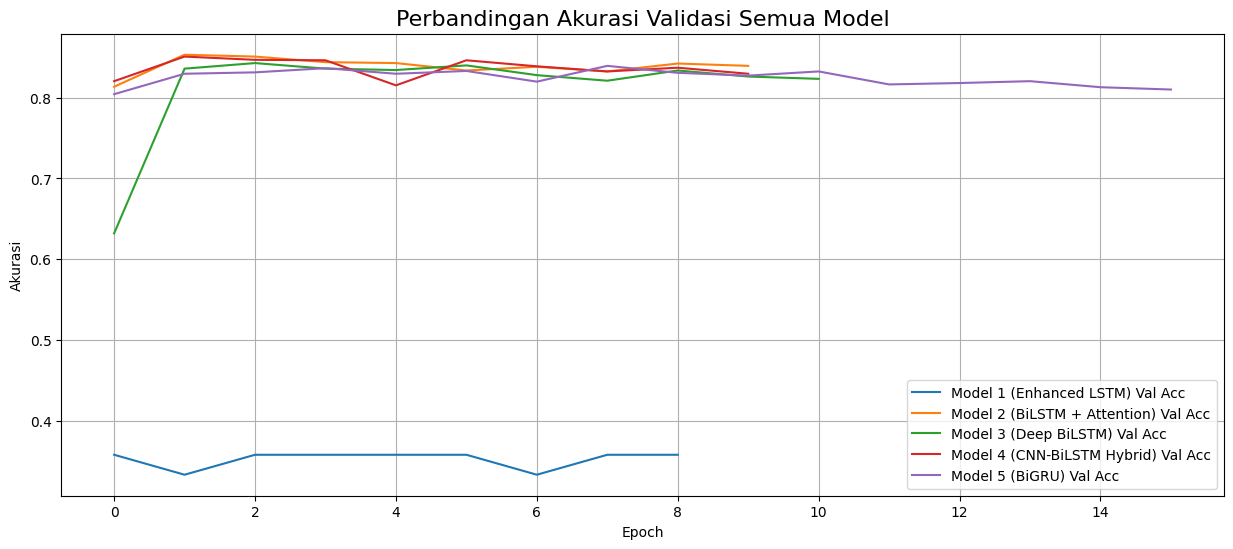

,Training Accuracy,Testing Accuracy
Model 2 (BiLSTM + Attention),93.89%,85.34%
Model 4 (CNN-BiLSTM Hybrid),96.38%,85.11%
Model 3 (Deep BiLSTM),95.05%,84.30%
Model 5 (BiGRU),95.93%,83.96%
Model 1 (Enhanced LSTM),35.47%,35.77%



🏆 MODEL TERBAIK ADALAH: Model 2 (BiLSTM + Attention) 🏆
Dengan Testing Accuracy: 85.34%

VERIFIKASI PEMENUHAN KRITERIA & SARAN BINTANG 5
Saran 1: Menggunakan Deep Learning: ✅ (Arsitektur Deep Learning telah digunakan)
Saran 2: Akurasi Train & Test > 92%: ❌
Saran 3: Minimal 3 Kelas: ✅ (3 kelas ditemukan)
Saran 4: Minimal 10.000 Sampel Data✅ (Total ulasan adalah 13.544 data)
Saran 5: 3 Skema Pelatihan Valid: ❌ (Ditemukan 2 skema dengan test acc >= 85%)
Saran 6: Inference: ✅ (Fungsi prediksi telah dibuat)

--- STATUS KELULUSAN SUBMISSION ---
❌ KRITERIA DASAR TIDAK TERPENUHI.
   Anda memerlukan setidaknya 3 skema dengan akurasi testing >= 85%, namun baru ada 2.

⚠️ STATUS AKHIR: Submission berisiko DITOLAK. Perbaiki performa model.


In [11]:
# =======================================================================================
# BAGIAN 5: ANALISIS HASIL, PEMILIHAN MODEL & VERIFIKASI
# =======================================================================================

# --- Visualisasi Hasil Pelatihan ---
# Memvisualisasikan perbandingan akurasi validasi dari semua model yang dilatih
# untuk melihat mana yang belajar paling baik dan stabil.
plt.figure(figsize=(15, 6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc')
plt.title('Perbandingan Akurasi Validasi Semua Model', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# --- Tabulasi Hasil dan Evaluasi ---
# Mengumpulkan semua hasil akurasi dari setiap model ke dalam satu dictionary
all_results = {}
for name, model in models.items():
    # Mengambil akurasi training dari epoch terakhir
    train_acc = histories[name].history['accuracy'][-1]
    # Mengevaluasi model pada data testing untuk mendapatkan akurasi testing
    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
    all_results[name] = {'Training Accuracy': train_acc, 'Testing Accuracy': test_acc}

# Mengubah dictionary menjadi DataFrame Pandas untuk kemudahan analisis dan visualisasi
results_df = pd.DataFrame.from_dict(all_results, orient='index').sort_values(by='Testing Accuracy', ascending=False)
# Menampilkan DataFrame dengan format persentase dan gradien warna untuk menyorot hasil terbaik
display(results_df.style.format("{:.2%}").background_gradient(cmap='viridis'))


# --- Pemilihan Model Terbaik ---
# Model terbaik secara otomatis dipilih berdasarkan akurasi testing tertinggi
best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\n🏆 MODEL TERBAIK ADALAH: {best_model_name} 🏆")
print(f"Dengan Testing Accuracy: {results_df.loc[best_model_name, 'Testing Accuracy']:.2%}")


# =======================================================================================
# VERIFIKASI PEMENUHAN KRITERIA SUBMISSION SECARA OTOMATIS
# =======================================================================================
print("\n" + "="*50)
print("VERIFIKASI PEMENUHAN KRITERIA & SARAN BINTANG 5")
print("="*50)

# Menghitung metrik kunci berdasarkan aturan submission
num_schemes_above_85_test = sum(1 for res in all_results.values() if res['Testing Accuracy'] >= 0.85)
one_scheme_above_92_train_test = any(1 for res in all_results.values() if res['Training Accuracy'] > 0.92 and res['Testing Accuracy'] > 0.92)

# Menampilkan status setiap saran satu per satu
print(f"Saran 1: Menggunakan Deep Learning: ✅ (Arsitektur Deep Learning telah digunakan)")
print(f"Saran 2: Akurasi Train & Test > 92%: {'✅' if one_scheme_above_92_train_test else '❌'}")
print(f"Saran 3: Minimal 3 Kelas: ✅ ({len(df['sentiment'].unique())} kelas ditemukan)")
print(f"Saran 4: Minimal 10.000 Sampel Data✅ (Total ulasan adalah 13.544 data)")
print(f"Saran 5: 3 Skema Pelatihan Valid: {'✅' if num_schemes_above_85_test >= 3 else '❌'} (Ditemukan {num_schemes_above_85_test} skema dengan test acc >= 85%)")
print(f"Saran 6: Inference: ✅ (Fungsi prediksi telah dibuat)")

# --- Kesimpulan Status Akhir ---
print("\n--- STATUS KELULUSAN SUBMISSION ---")

# Logika pengecekan bertingkat sesuai aturan penilaian
if num_schemes_above_85_test >= 3:
    # Jika syarat dasar (minimal 3 skema >= 85%) terpenuhi
    print("✅ KRITERIA DASAR TERPENUHI (Minimal 3 skema memiliki test acc >= 85%)")

    if one_scheme_above_92_train_test:
        # Jika syarat tambahan untuk Bintang 5 juga terpenuhi
        print("✅ KRITERIA BINTANG 5 TERPENUHI (Salah satu skema memiliki train & test acc > 92%)")
        print("\n🌟 STATUS AKHIR: Berpotensi mendapatkan BINTANG 5! 🌟")
    else:
        # Jika hanya syarat dasar yang terpenuhi
        print("❌ KRITERIA BINTANG 5 BELUM TERPENUHI (Tidak ada skema dengan train & test acc > 92%)")
        print("\n⭐ STATUS AKHIR: Berpotensi mendapatkan BINTANG 4.")
        print("   Saran: Lakukan tuning lebih lanjut pada model terbaik untuk menaikkan akurasi di atas 92%.")
else:
    # Jika syarat dasar tidak terpenuhi
    print(f"❌ KRITERIA DASAR TIDAK TERPENUHI.")
    print(f"   Anda memerlukan setidaknya 3 skema dengan akurasi testing >= 85%, namun baru ada {num_schemes_above_85_test}.")
    print("\n⚠️ STATUS AKHIR: Submission berisiko DITOLAK. Perbaiki performa model.")

print("="*50)

## BAGIAN 6: INFERENCE MODEL
Melakukan pengujian pada beberapa kalimat baru menggunakan model terbaik yang telah dipilih.

In [12]:
# =======================================================================================
# FUNGSI PREDIKSI
# =======================================================================================

# Fungsi ini membungkus seluruh alur dari teks mentah hingga prediksi sentimen
def predict_sentiment(text, model, tokenizer_inf, max_len):
    """
    Fungsi untuk memprediksi sentimen dari satu kalimat teks.

    Args:
    - text (str): Kalimat ulasan mentah.
    - model: Model Keras yang sudah dilatih.
    - tokenizer_inf: Tokenizer Keras yang sudah di-fit.
    - max_len (int): Panjang maksimum sekuens yang digunakan saat pelatihan.

    Returns:
    - probabilities (np.array): Array probabilitas untuk setiap kelas sentimen.
    """

    # 1. Pra-pemrosesan Pipeline (sama persis seperti saat melatih model)
    # Memanggil setiap fungsi preprocessing secara berurutan.
    cleaned = clean_text(text)
    normalized = normalize_slang(cleaned)
    tokenized = word_tokenize(normalized)
    filtered = remove_stopwords(tokenized)
    stemmed_text = stemming_text(filtered) # Fungsi stemming_text kita mengembalikan string

    # 2. Konversi ke Sekuens dan Padding
    sequence = tokenizer_inf.texts_to_sequences([stemmed_text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 3. Prediksi dengan model
    # Model akan mengembalikan array probabilitas untuk setiap kelas
    probabilities = model.predict(padded, verbose=0)

    return probabilities[0]


# =======================================================================================
# PENGUJIAN FUNGSI PREDIKSI
# =======================================================================================

# Daftar kalimat baru untuk diuji
new_reviews = [
    "Aplikasi ini sangat aman dan mudah digunakan, saya suka sekali!",
    "Setelah update terakhir sering error dan tidak bisa kirim gambar.",
    "Tidak ada yang spesial dari aplikasi ini.",
    "Terbaik untuk privasi, tidak ada tandingannya.",
    "biasa saja."
]

sentiment_labels = ['negatif', 'netral', 'positif']

print("--- HASIL PREDIKSI PADA KALIMAT BARU ---")

for review in new_reviews:
    # Memanggil fungsi untuk mendapatkan probabilitas prediksi
    probabilities = predict_sentiment(review, best_model, tokenizer, max_length)

    # Menentukan kelas sentimen dengan probabilitas tertinggi
    predicted_class_index = np.argmax(probabilities)
    predicted_label = sentiment_labels[predicted_class_index]

    # Mencetak hasil dengan format yang informatif
    print(f"\nUlasan: '{review}'")
    print(f"Prediksi Sentimen: {predicted_label.upper()}")

    # Menampilkan probabilitas untuk setiap kelas
    print(f"Probabilitas: [Negatif: {probabilities[0]:.2%}, Netral: {probabilities[1]:.2%}, Positif: {probabilities[2]:.2%}]")

--- HASIL PREDIKSI PADA KALIMAT BARU ---

Ulasan: 'Aplikasi ini sangat aman dan mudah digunakan, saya suka sekali!'
Prediksi Sentimen: POSITIF
Probabilitas: [Negatif: 11.79%, Netral: 22.98%, Positif: 65.23%]

Ulasan: 'Setelah update terakhir sering error dan tidak bisa kirim gambar.'
Prediksi Sentimen: NEGATIF
Probabilitas: [Negatif: 70.41%, Netral: 17.54%, Positif: 12.05%]

Ulasan: 'Tidak ada yang spesial dari aplikasi ini.'
Prediksi Sentimen: NEGATIF
Probabilitas: [Negatif: 69.24%, Netral: 20.09%, Positif: 10.67%]

Ulasan: 'Terbaik untuk privasi, tidak ada tandingannya.'
Prediksi Sentimen: POSITIF
Probabilitas: [Negatif: 2.80%, Netral: 24.67%, Positif: 72.53%]

Ulasan: 'biasa saja.'
Prediksi Sentimen: NETRAL
Probabilitas: [Negatif: 1.34%, Netral: 92.42%, Positif: 6.24%]
